In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import r2_score


In [2]:
Data_put = pd.read_csv('/Users/judd/Desktop/Uni/Sem 2 2024/3888/project/DATA/put_data_sept_13_clean.csv')
Data_call = pd.read_csv('/Users/judd/Desktop/Uni/Sem 2 2024/3888/project/DATA/call_data_sept_13_clean.csv')
ML_volatility = pd.read_csv('/Users/judd/Desktop/Uni/Sem 2 2024/3888/project/DATA/ML_volatility.csv')



## DATA WAS CLEANSED BY REMOVING MARKETS THAT LOOKED UNREALISTIC i.e Extremly high strike prices. 

In [3]:


ML_volatility.rename(columns={'Stock': 'stock'}, inplace=True)
# Merge the two dataframes on the 'stock' column
Data_call = pd.merge(Data_call, ML_volatility[['stock', 'Predictions']], on='stock', how='left')

# Rename 'Predictions' to 'ML_volatility' to match your naming convention
Data_call.rename(columns={'Predictions': 'ML_volatility'}, inplace=True)


Data_put = pd.merge(Data_put, ML_volatility[['stock', 'Predictions']], on='stock', how='left')

# Rename 'Predictions' to 'ML_volatility' to match your naming convention
Data_put.rename(columns={'Predictions': 'ML_volatility'}, inplace=True)



In [4]:
len(Data_call['stock'].unique())

len(Data_call)+len(Data_put)

8695

In [5]:
### ADD BS PREDICTIONS FOR VARIOUS SIGMA VALUES TO DATA ###

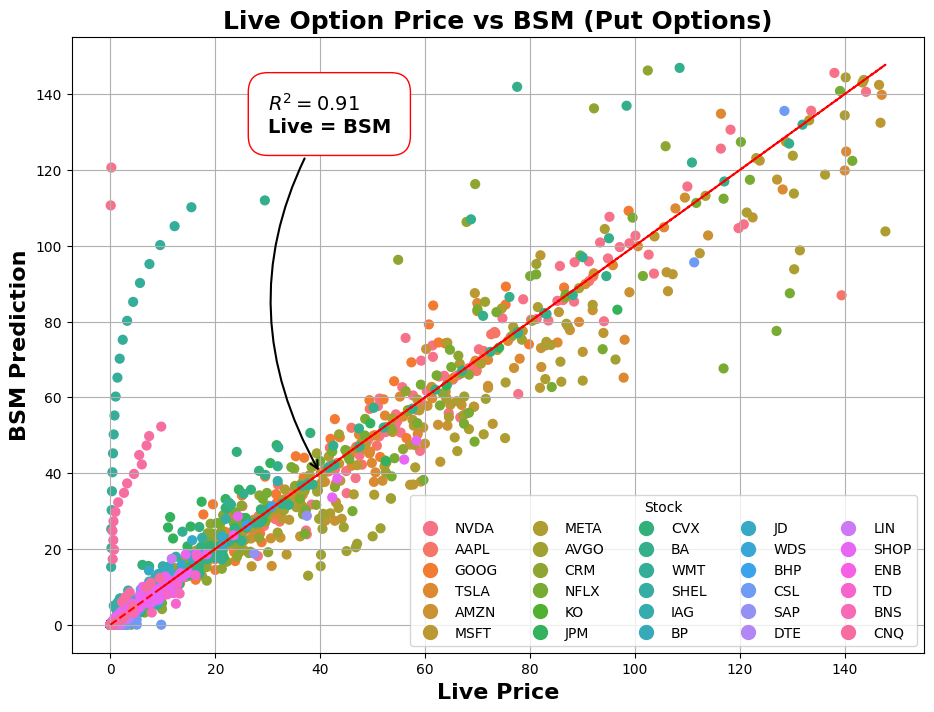

R-squared: 0.91


In [6]:
Data_put_adjusted = Data_put[(Data_put['live_last_price'] <= 150) & (Data_put['bsm'] <= 150)]

# Set up a color palette using seaborn
unique_stocks = Data_put_adjusted['stock'].unique()
palette = sns.color_palette("husl", len(unique_stocks))

# Map each stock to a different color
color_mapping = dict(zip(unique_stocks, palette))
colors = Data_put_adjusted['stock'].map(color_mapping)
legend_labels = [plt.Line2D([0], [0], marker='o', color=col, label=stock, markersize=10, linestyle='') for stock, col in color_mapping.items()]

#R2
r_squared = r2_score(Data_put_adjusted['live_last_price'], Data_put_adjusted['bsm'] )

#Plot
x_values = Data_put_adjusted['live_last_price']
plt.figure(figsize=(11, 8))  

# Plotting the scatter plot
scatter = plt.scatter(Data_put_adjusted['live_last_price'], Data_put_adjusted['bsm'], c=colors, marker='o', s=40, label='Live Price vs BSM')
plt.plot(x_values, x_values, color='r', linestyle='--', label='Live Price = BSM')  # Line y = x


# Set labels and title with improved formatting
plt.xlabel('Live Price', fontsize=16, fontweight='bold')
plt.ylabel('BSM Prediction', fontsize=16, fontweight='bold')
plt.title('Live Option Price vs BSM (Put Options)', fontsize=18, fontweight='bold')


# Combined R² and "Live = BSM" in a single text box
combined_text = f"$R^2 = {r_squared:.2f}$\nLive = BSM"

# Add the combined annotation with arrow
plt.annotate(
    combined_text, xy=(40, 40), xytext=(30, 130), fontsize=14, fontweight='bold',
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=1'),  # Bounding box around text
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5, connectionstyle="arc3,rad=.3"), color='black'
)


# Show the legend with larger font size and title
plt.legend(fontsize=14, title_fontsize=14)

plt.legend(handles=legend_labels,loc='lower right', ncol=5, title='Stock')


# Show the grid
plt.grid(True)

# Show the plot
plt.show()

# Print the R² value for reference in the console
print(f"R-squared: {r_squared:.2f}")



In [30]:
from scipy.stats import shapiro
from scipy.stats import wilcoxon

# Calculate the difference between the live price and BSM
price_diff = Data_put_adjusted['live_last_price'] - Data_put_adjusted['bsm']

# Perform the Shapiro-Wilk test for normality
shapiro_test = shapiro(price_diff)
print(f'Shapiro-Wilk Test p-value: {shapiro_test.pvalue}')


w_stat, p_value = wilcoxon(Data_put_adjusted['live_last_price'], Data_put_adjusted['bsm'])
print(f'Wilcoxon signed-rank test p-value: {p_value}')


from scipy.stats import ttest_rel

# Paired t-test
t_stat, p_value = ttest_rel(Data_put_adjusted['live_last_price'], Data_put_adjusted['bsm'])
print(f'Paired t-test p-value: {p_value}')

Shapiro-Wilk Test p-value: 1.134179550994557e-81
Wilcoxon signed-rank test p-value: 1.5761265179341372e-158
Paired t-test p-value: 0.4286497163849492


In [40]:
import pandas as pd
from scipy.stats import shapiro, ttest_rel, wilcoxon

# Assuming you have separate dataframes for `Data_put_adjusted` and `Data_call_adjusted`
put_data = Data_put_adjusted
call_data = Data_call_adjusted

# Significance level for hypothesis testing
significance_level = 0.05

# Prepare a list to store results
results = []

# Function to perform statistical testing and collect results
def perform_stat_tests(df, option_type):
    # Group by stock identifier
    grouped = df.groupby('stock')
    for stock_name, group in grouped:
        live_price = group['live_last_price']
        bsm_price = group['bsm']
        
        # Calculate the differences
        price_diff = live_price - bsm_price

        # Perform Shapiro-Wilk test for normality
        shapiro_p = shapiro(price_diff).pvalue
        
        # Choose and perform the appropriate statistical test
        if shapiro_p > significance_level:
            # Paired t-test (for normal distribution)
            t_stat, p_value = ttest_rel(live_price, bsm_price)
            test_type = 'Paired t-test'
        else:
            # Wilcoxon signed-rank test (for non-normal distribution)
            w_stat, p_value = wilcoxon(live_price, bsm_price)
            test_type = 'Wilcoxon signed-rank test'

        # Determine if the null hypothesis is rejected
        null_hypothesis_result = 'Rejected' if p_value < significance_level else 'Accepted'

        # Store results with the option type included
        results.append({
            'Stock': stock_name, 
            'Option Type': option_type,
            'Test Type': test_type, 
            'p-value': p_value, 
            'Normality p-value': shapiro_p, 
            'Null Hypothesis': null_hypothesis_result
        })

# Perform the tests for Put options
perform_stat_tests(put_data, option_type='Put')

# Perform the tests for Call options
perform_stat_tests(call_data, option_type='Call')

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Calculate percentages of rejected and accepted for each option type
summary = results_df.groupby(['Option Type', 'Null Hypothesis']).size().unstack().fillna(0)
summary['Total'] = summary.sum(axis=1)
summary['% Rejected'] = (summary['Rejected'] / summary['Total']) * 100
summary['% Accepted'] = (summary['Accepted'] / summary['Total']) * 100

# Display the individual test results to the user

results_df



#If you observe that the null hypothesis is rejected for either option type, it indicates a significant difference for that specific stock and option type.

,Stock,Option Type,Test Type,p-value,Normality p-value,Null Hypothesis
0,AAPL,Put,Wilcoxon signed-rank test,1.495899e-13,3.364173e-28,Rejected
1,AMZN,Put,Wilcoxon signed-rank test,1.071083e-15,7.077827e-21,Rejected
2,AVGO,Put,Wilcoxon signed-rank test,1.880784e-28,3.440365e-30,Rejected
3,BA,Put,Wilcoxon signed-rank test,2.715509e-08,1.678139e-24,Rejected
4,BHP,Put,Wilcoxon signed-rank test,1.708984e-02,2.225647e-02,Rejected
5,BNS,Put,Wilcoxon signed-rank test,1.953125e-03,2.111210e-05,Rejected
6,BP,Put,Wilcoxon signed-rank test,7.775732e-02,8.649664e-13,Accepted
7,CNQ,Put,Wilcoxon signed-rank test,8.127291e-05,2.800368e-05,Rejected
8,CRM,Put,Wilcoxon signed-rank test,8.757635e-02,1.159125e-22,Accepted
9,CSL,Put,Paired t-test,8.466782e-02,2.139914e-01,Accepted


In [41]:
summary

Null Hypothesis,Accepted,Rejected,Total,% Rejected,% Accepted
Option Type,,,,,
Call,11,19,30,63.333333,36.666667
Put,8,22,30,73.333333,26.666667


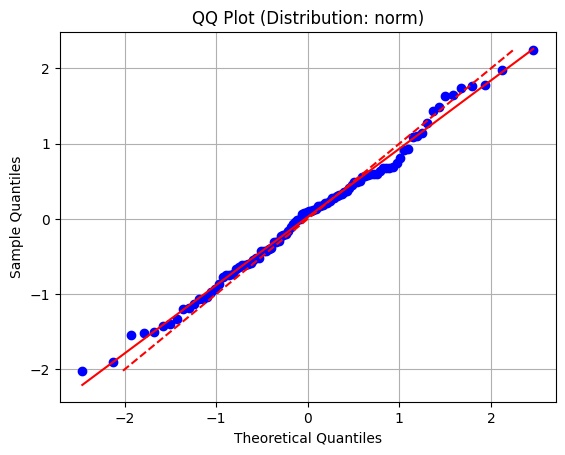

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def qq_plot(data, distribution='norm', line='45'):
    """
    Generates a QQ plot to compare the quantiles of the input data against a theoretical distribution.

    Parameters:
    -----------
    data : array-like
        The data to be compared against a theoretical distribution.
    distribution : str, optional
        The type of theoretical distribution to compare against (default is 'norm' for normal distribution).
    line : str, optional
        The type of reference line to add ('45', 's', or 'q'):
        - '45' : Add a 45-degree line (default).
        - 's' : Add a standardized line.
        - 'q' : Add a line through the quartiles.
        
    Returns:
    --------
    None. Displays the QQ plot.
    """
    # Generate the QQ plot
    stats.probplot(data, dist=distribution, plot=plt)

    # Customize the line option
    if line == '45':
        plt.plot([min(data), max(data)], [min(data), max(data)], linestyle='--', color='r')
    elif line in ['s', 'q']:
        pass  # The line is handled by the built-in probplot function

    plt.title(f"QQ Plot (Distribution: {distribution})")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

# Example usage:
import numpy as np
sample_data = np.random.normal(0, 1, 100)
qq_plot(sample_data, distribution='norm', line='45')


In [7]:
import numpy as np
from scipy.stats import norm

# Given parameters
volatility = 0.516076674  # Volatility (sigma)
strike_price = 130  # Strike Price (K)
time_in_days = 21  # Time in days
time_to_expiry = time_in_days / 365  # Convert time to years
current_stock_price = 119.14  # Assume a current stock price for the example
risk_free_rate = 0.05  # Assume a risk-free rate of 5%

# Calculate d1 and d2
d1 = (np.log(current_stock_price / strike_price) + (risk_free_rate + (volatility ** 2) / 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
d2 = d1 - volatility * np.sqrt(time_to_expiry)

# Calculate the call and put option prices
call_price = current_stock_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(d2)
put_price = strike_price * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(-d2) - current_stock_price * norm.cdf(-d1)

# Output the results
print(f"Black-Scholes Call Option Price: ${call_price:.2f}")
print(f"Black-Scholes Put Option Price: ${put_price:.2f}")


Black-Scholes Call Option Price: $2.27
Black-Scholes Put Option Price: $12.75


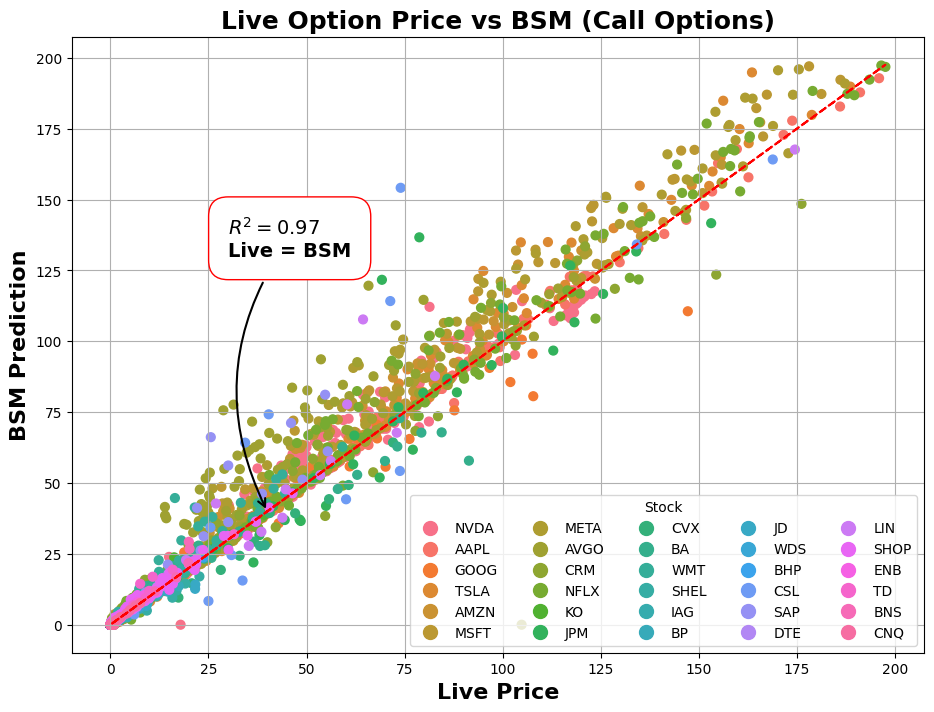

R-squared: 0.97


In [8]:
Data_call_adjusted = Data_call[(Data_call['live_last_price'] <= 200) & (Data_call['bsm'] <= 200)]

# Set up a color palette using seaborn
unique_stocks = Data_call_adjusted['stock'].unique()
palette = sns.color_palette("husl", len(unique_stocks))

# Map each stock to a different color
color_mapping = dict(zip(unique_stocks, palette))
colors = Data_call_adjusted['stock'].map(color_mapping)
legend_labels = [plt.Line2D([0], [0], marker='o', color=col, label=stock, markersize=10, linestyle='') for stock, col in color_mapping.items()]

#R2
r_squared = r2_score(Data_call_adjusted['live_last_price'], Data_call_adjusted['bsm'] )

#Plot
x_values = Data_call_adjusted['live_last_price']
plt.figure(figsize=(11, 8))  

# Plotting the scatter plot
scatter = plt.scatter(Data_call_adjusted['live_last_price'], Data_call_adjusted['bsm'], c=colors, marker='o', s=40, label='Live Price vs BSM')
plt.plot(x_values, x_values, color='r', linestyle='--', label='Live Price = BSM')  # Line y = x


# Set labels and title with improved formatting
plt.xlabel('Live Price', fontsize=16, fontweight='bold')
plt.ylabel('BSM Prediction', fontsize=16, fontweight='bold')
plt.title('Live Option Price vs BSM (Call Options)', fontsize=18, fontweight='bold')


# Combined R² and "Live = BSM" in a single text box
combined_text = f"$R^2 = {r_squared:.2f}$\nLive = BSM"

# Add the combined annotation with arrow
plt.annotate(
    combined_text, xy=(40, 40), xytext=(30, 130), fontsize=14, fontweight='bold',
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=1'),  # Bounding box around text
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5, connectionstyle="arc3,rad=.3"), color='black'
)


# Show the legend with larger font size and title
plt.legend(fontsize=14, title_fontsize=14)

plt.legend(handles=legend_labels,loc='lower right', ncol=5, title='Stock')


# Show the grid
plt.grid(True)

# Show the plot
plt.show()

# Print the R² value for reference in the console
print(f"R-squared: {r_squared:.2f}")



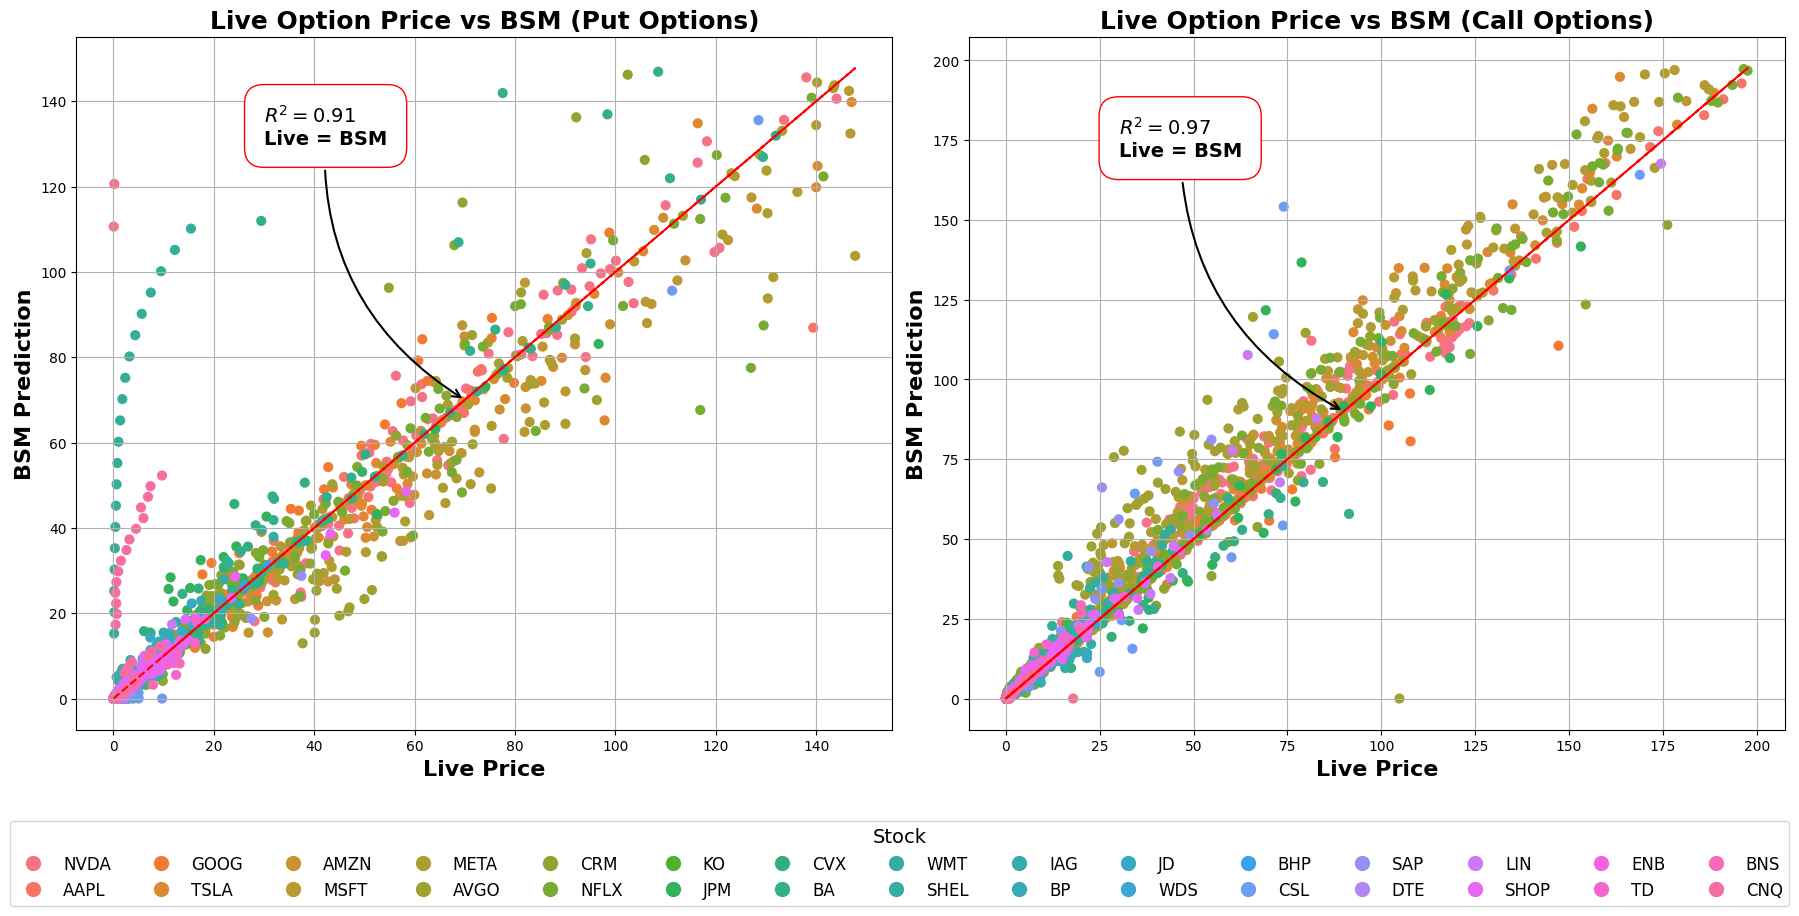

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Assuming Data_put_adjusted and Data_call_adjusted are already defined DataFrames

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  # Adjust figure size as needed

### Plot 1: Put Options ###
# Set up color palette using seaborn
unique_stocks_put = Data_put_adjusted['stock'].unique()
palette_put = sns.color_palette("husl", len(unique_stocks_put))
color_mapping_put = dict(zip(unique_stocks_put, palette_put))
colors_put = Data_put_adjusted['stock'].map(color_mapping_put)

# Create legend handles for common legend
legend_labels = [plt.Line2D([0], [0], marker='o', color=col, label=stock, markersize=10, linestyle='') for stock, col in color_mapping_put.items()]

# Calculate R² for Put Options
r_squared_put = r2_score(Data_put_adjusted['live_last_price'], Data_put_adjusted['bsm'])

# Plot the scatter plot for Put Options
ax1.scatter(
    Data_put_adjusted['live_last_price'], 
    Data_put_adjusted['bsm'], 
    c=colors_put, marker='o', s=40, label='Live Price vs BSM'
)
ax1.plot(
    Data_put_adjusted['live_last_price'], Data_put_adjusted['live_last_price'], 
    color='r', linestyle='--', label='Live Price = BSM'
)
ax1.set_xlabel('Live Price', fontsize=16, fontweight='bold')
ax1.set_ylabel('BSM Prediction', fontsize=16, fontweight='bold')
ax1.set_title('Live Option Price vs BSM (Put Options)', fontsize=18, fontweight='bold')

# Add combined R² and annotation for Put Options
combined_text_put = f"$R^2 = {r_squared_put:.2f}$\nLive = BSM"
ax1.annotate(
    combined_text_put, xy=(70, 70), xytext=(30, 130), fontsize=14, fontweight='bold',
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=1'),
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5, connectionstyle="arc3,rad=.3"), color='black'
)
ax1.grid(True)

### Plot 2: Call Options ###
# Set up color palette using seaborn
unique_stocks_call = Data_call_adjusted['stock'].unique()
palette_call = sns.color_palette("husl", len(unique_stocks_call))
color_mapping_call = dict(zip(unique_stocks_call, palette_call))
colors_call = Data_call_adjusted['stock'].map(color_mapping_call)

# Calculate R² for Call Options
r_squared_call = r2_score(Data_call_adjusted['live_last_price'], Data_call_adjusted['bsm'])

# Plot the scatter plot for Call Options
ax2.scatter(
    Data_call_adjusted['live_last_price'], 
    Data_call_adjusted['bsm'], 
    c=colors_call, marker='o', s=40, label='Live Price vs BSM'
)
ax2.plot(
    Data_call_adjusted['live_last_price'], Data_call_adjusted['live_last_price'], 
    color='r', linestyle='--', label='Live Price = BSM'
)
ax2.set_xlabel('Live Price', fontsize=16, fontweight='bold')
ax2.set_ylabel('BSM Prediction', fontsize=16, fontweight='bold')
ax2.set_title('Live Option Price vs BSM (Call Options)', fontsize=18, fontweight='bold')

# Add combined R² and annotation for Call Options
combined_text_call = f"$R^2 = {r_squared_call:.2f}$\nLive = BSM"
ax2.annotate(
    combined_text_call, xy=(90, 90), xytext=(30, 170), fontsize=14, fontweight='bold',
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=1'),
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5, connectionstyle="arc3,rad=.3"), color='black'
)
ax2.grid(True)

# Add a single legend for both subplots
fig.legend(handles=legend_labels, loc='lower center', ncol=15, title='Stock', fontsize=12, title_fontsize=14, frameon=True, bbox_to_anchor=(0.5, -0.15))

# Adjust layout to fit both subplots and legend
plt.tight_layout()

# Show the combined plot
plt.show()


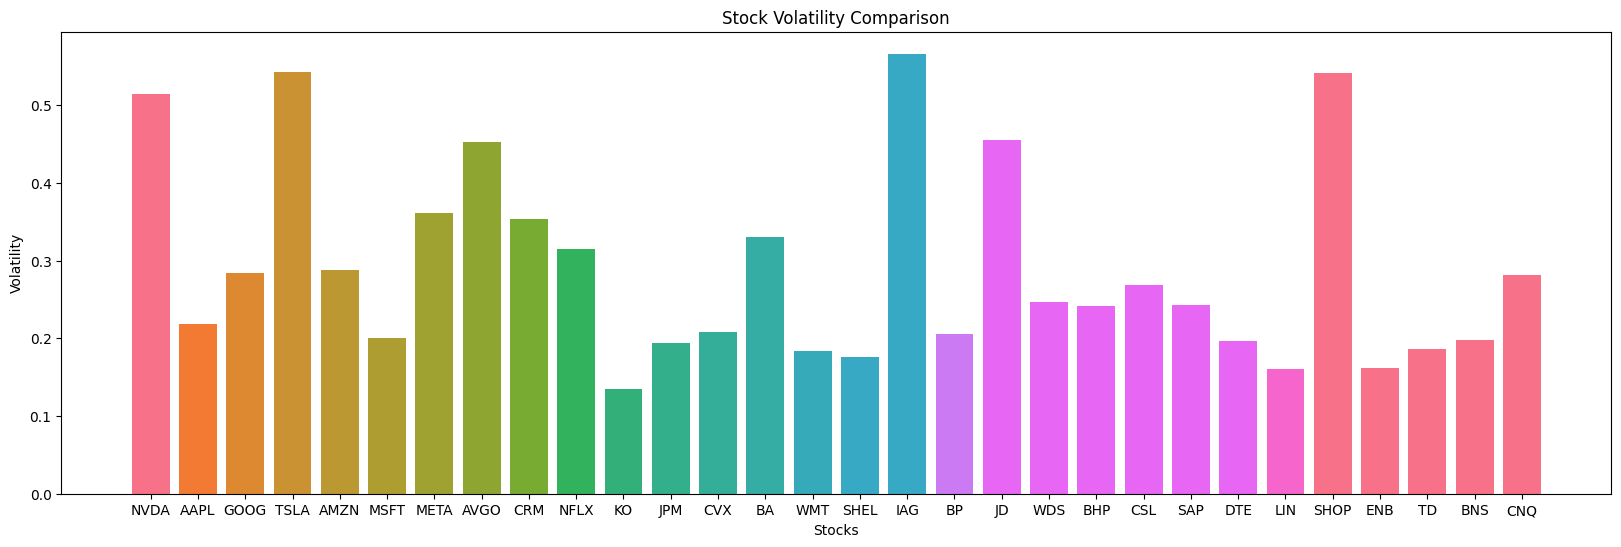

In [10]:
###PLOT VOLATILITY ####

#### MAKE THIS A BAR CHART A STAKCED CHART WITH DIFFERNT VOLATITIES OR EACH STOCK ###

stocks = Data_call['stock']
volatility = Data_call['sigma']

plt.figure(figsize=(20, 6))  # Set the figure size
plt.bar(stocks, volatility, color=colors)

# Add labels and title
plt.xlabel('Stocks')
plt.ylabel('Volatility')
plt.title('Stock Volatility Comparison')

# Show the plot
plt.show()

In [11]:
### BEWARE FROM THE BELOW CELLS ONWARD DATA CALL AND DATA PUT ARE BEING CUT SO THEY ONLY HAVE THE RELEVANT DATA IE MARKETS WHERE WE CAN GET STOCK DATA AT EXPIRY DATE ###

In [12]:
#### ADDING DATA TO DATA CALL #####

cutoff_date = datetime.today()
Data_call['expiry_date'] = pd.to_datetime(Data_call['expiry_date'])
Data_call = Data_call[Data_call['expiry_date'] <= cutoff_date]

# Add empty columns for stock market and closing price
Data_call['market'] = ''
Data_call['closing_price_at_expiry'] = 0.0

download_date = '2024-09-12'
# Iterate over the unique stock tickers in the dataframe
for ticker in Data_call['stock'].unique():
    try:
        # Fetch the ticker information
        stock_info = yf.Ticker(ticker)
        
        # Get the stock exchange name
        market = stock_info.info.get('exchange', 'Unknown')
        
        # Filter the rows that match the current ticker
        ticker_rows = Data_call['stock'] == ticker
        
        # Update the market column for the matching rows
        Data_call.loc[ticker_rows, 'market'] = market

        # Get the historical stock prices for the entire date range
        historical_data = stock_info.history(period='max')

        download_date_price = historical_data.loc[download_date]['Close']

        # Iterate through the rows with the current ticker
        for index, row in Data_call[ticker_rows].iterrows():
            expiry_date = pd.Timestamp(row['expiry_date']).strftime('%Y-%m-%d')

            Data_call.at[index, 'stock_price_on_data_download_date'] = download_date_price

            Data_call.at[index, 'closing_price_at_expiry'] = historical_data.loc[expiry_date]['Close']
    except Exception as e:
        print(f"Error processing {ticker}: {e}")



/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_39786/3562224869.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Data_call['expiry_date'] = pd.to_datetime(Data_call['expiry_date'])


In [13]:
#### ADDING DATA TO DATA PUT #####

# Set today's date as the cutoff
cutoff_date = datetime.today()

# Convert expiry_date column to datetime format
Data_put['expiry_date'] = pd.to_datetime(Data_put['expiry_date'])

# Filter the dataframe to include only rows with expiry_date less than or equal to today's date
Data_put = Data_put[Data_put['expiry_date'] <= cutoff_date]

# Add empty columns for stock market and closing price
Data_put['market'] = ''
Data_put['closing_price_at_expiry'] = 0.0

# Define the download date for historical prices
download_date = '2024-09-13'

# Iterate over the unique stock tickers in the dataframe
for ticker in Data_put['stock'].unique():
    try:
        # Fetch the ticker information from Yahoo Finance
        stock_info = yf.Ticker(ticker)
        
        # Get the stock exchange name
        market = stock_info.info.get('exchange', 'Unknown')
        
        # Filter the rows that match the current ticker
        ticker_rows = Data_put['stock'] == ticker
        
        # Update the market column for the matching rows
        Data_put.loc[ticker_rows, 'market'] = market

        # Get the historical stock prices for the entire date range
        historical_data = stock_info.history(period='max')

        # Get the stock price on the download date
        download_date_price = historical_data.loc[download_date]['Close']

        # Iterate through the rows with the current ticker to update prices
        for index, row in Data_put[ticker_rows].iterrows():
            expiry_date = pd.Timestamp(row['expiry_date']).strftime('%Y-%m-%d')
            
            # Update stock price on download date
            Data_put.at[index, 'stock_price_on_data_download_date'] = download_date_price

            # Update closing price at expiry
            Data_put.at[index, 'closing_price_at_expiry'] = historical_data.loc[expiry_date]['Close']
    except Exception as e:
        print(f"Error processing {ticker}: {e}")


/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_39786/993769337.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Data_put['expiry_date'] = pd.to_datetime(Data_put['expiry_date'])


In [14]:
len(Data_call)+len(Data_put)

7858

In [15]:
### ANALYSIS 1 ####

### COMPUTE PROFIT/LOSS ON PURCHASE OF A SINGLE OPTION AT LIVE PRICE 


### For a put option you win if at the expiry date the stock price is below the strike price by more then the option price you paid. 
# Then you can buy the shares at the low stock price and immediatley sell them at the higher strike price. owever your net profit must consider the price of the option. 
# The option writer/stock broker is the one who must purchase the shares at the higher price and hence looses the amount you win. Conversly if you loose, then the option writer wins. ####

### For a call option you win if at the expiry date the stock price is above the strike price by more then the option price you paid for the option. 
# Then you can purchase the stock price for the strike price i.e at a discount and immediatly sell it at the live stock price for a profit. However your net profit must consider the price of the option####
# The option writer/stock broker is the one who must sell yoy the shares at the lower price and hence looses the amount you win. Conversly if you loose, then the option writer wins. ####


### One options contract gives right to buy or sell 100 shares but price is quoted per share  ####

Data_put['profit']  = np.where(
        Data_put['strike_price'] - Data_put['closing_price_at_expiry'] - Data_put['live_last_price'] > -Data_put['live_last_price'],
        Data_put['strike_price'] - Data_put['closing_price_at_expiry'] - Data_put['live_last_price'],
        -Data_put['live_last_price']
    )

Data_call['profit'] = np.where(
        Data_call['closing_price_at_expiry'] -  Data_call['strike_price'] - Data_call['live_last_price'] > -Data_call['live_last_price'],
       Data_call['closing_price_at_expiry'] - Data_call['strike_price'] - Data_call['live_last_price'],
       -Data_call['live_last_price'])


Data_put['profit_bsm_base']  = np.where(
        Data_put['strike_price'] - Data_put['closing_price_at_expiry'] - Data_put['bsm'] > -Data_put['bsm'],
        Data_put['strike_price'] - Data_put['closing_price_at_expiry'] - Data_put['live_last_price'],
        -Data_put['bsm']
    )

Data_call['profit_bsm_base'] = np.where(
        Data_call['closing_price_at_expiry'] -  Data_call['strike_price'] - Data_call['bsm'] > -Data_call['bsm'],
       Data_call['closing_price_at_expiry'] - Data_call['strike_price'] - Data_call['bsm'],
       -Data_call['bsm'])

#### IF BS MODEL MORE THEN MARKET PRICE THEN ADD IT TO OUR PORTFOLIO OF PURCHASED OPTIONS ######

def generate_portfolios(Data_call, Data_put):
    portfolio_call = Data_call[Data_call['bsm'] >= Data_call['live_last_price']]
    portfolio_put = Data_put[Data_put['bsm'] >= Data_put['live_last_price']]
    not_portfolio_call = Data_call[Data_call['bsm'] < Data_call['live_last_price']]
    not_portfolio_put = Data_put[Data_put['bsm'] < Data_put['live_last_price']]
    
    return portfolio_put, not_portfolio_put, portfolio_call, not_portfolio_call

#### Stats #####

def calculate_profit_stats(df, call = True):

    if call == True:
        portfolio_size = len(df)/len(Data_call)
    else:
        portfolio_size = len(df)/len(Data_put)
    
    # Calculate the number of rows with positive profit
    num_positive_profit_rows = len(df[df['profit'] > 0.5])
    
    # Calculate the number of rows with negative profit
    num_negative_profit_rows = len(df[df['profit'] < 0.5])
    
    
    # Calculate percentages
    percent_positive = (num_positive_profit_rows / len(df)) * 100 
    percent_negative = (num_negative_profit_rows / len(df)) * 100 

    # Calculate the total profit (sum of all profit values)
    total_profit = df['profit'].sum() / sum(df['live_last_price'])  #### Return on Investment (ROI)

    return  portfolio_size, num_positive_profit_rows, total_profit, percent_positive, percent_negative

# Function to create 4 pie charts in a single figure with enhanced text annotations
def generate_four_pie_charts(stats1, stats2, stats3, stats4, titles):
    # Unpack the titles
    title1, title2, title3, title4, title5 = titles
    
    # Create a smaller 2x2 subplot structure with adjusted figure size
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))  # Increase the size for a cleaner look

    # Data for each pie chart
    chart_data = [
        (stats1, axs[0, 0], title1),
        (stats2, axs[0, 1], title2),
        (stats3, axs[1, 0], title3),
        (stats4, axs[1, 1], title4)
    ]

    # Updated colors: rich blue and red
    colors = ['#1bc411', '#f7270f']  # Standard rich blue and red

    # Generate pie charts for each subplot
    for stats, ax, title in chart_data:
        portfolio_size, _, total_profit, percent_positive, percent_negative = stats
        sizes = [percent_positive, percent_negative]
        labels = ['Won', 'Lost']

        # Create the pie chart
        wedges, texts, autotexts = ax.pie(
            sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=40, textprops={'fontsize': 9}
        )
        ax.set_title(title, fontsize=11, weight='bold')
        ax.axis('equal')  # Ensures the pie is drawn as a circle

        # Customize the text properties inside the pie
        for autotext in autotexts:
            autotext.set_fontsize(10)
            autotext.set_weight('bold')
            autotext.set_color('white')  # Change color to white for better readability

        # Customize the labels outside the pie chart ("Won" and "Lost") to match the text style
        for text in texts:
            text.set_fontsize(10)
            

        # Format portfolio size with commas and format total profit using custom format
        formatted_profit = f"{total_profit * 100:.1f}%"
        formatted_size = f"{portfolio_size * 100:.1f}%"  # Display size as a percentage with 2 decimal places


        # Add portfolio size and total profit in the center of the pie chart with a custom text box
        textstr = f"Size: {formatted_size}\nROI: {formatted_profit}"
        ax.text(
            0, 0, textstr, ha='center', va='center', fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
        )


    # Add an overall title to the entire figure
    fig.suptitle(title5, fontsize=14, weight = 'bold')
    
    # Display the pie charts
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust layout to fit the main title
    plt.show()


4007
3851


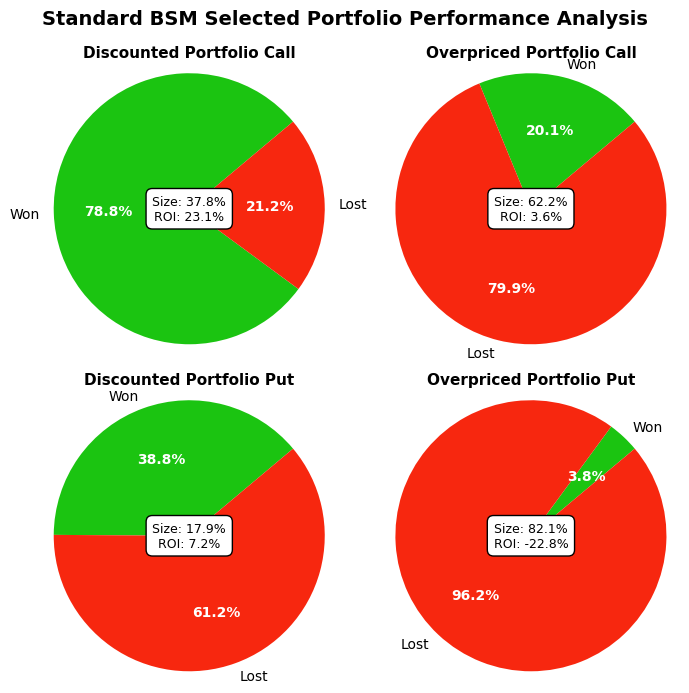

In [16]:

portfolio_put, not_portfolio_put, portfolio_call, not_portfolio_call = generate_portfolios(Data_call, Data_put)

print(len(Data_call))
print(len(Data_put))


portfolio_call_stats  = calculate_profit_stats(portfolio_call, True)
not_portfolio_call_stats  = calculate_profit_stats(not_portfolio_call, True)
portfolio_put_stats  = calculate_profit_stats(portfolio_put, False)
not_portfolio_put_stats  = calculate_profit_stats(not_portfolio_put, False)


# Titles for each chart
titles = [
    "Discounted Portfolio Call",
    "Overpriced Portfolio Call",
    "Discounted Portfolio Put",
    "Overpriced Portfolio Put",
    "Standard BSM Selected Portfolio Performance Analysis"
]

# Generate a single figure with four pie charts using the updated stats
generate_four_pie_charts(
    portfolio_call_stats, not_portfolio_call_stats,
    portfolio_put_stats, not_portfolio_put_stats,
    titles)

2793
2654


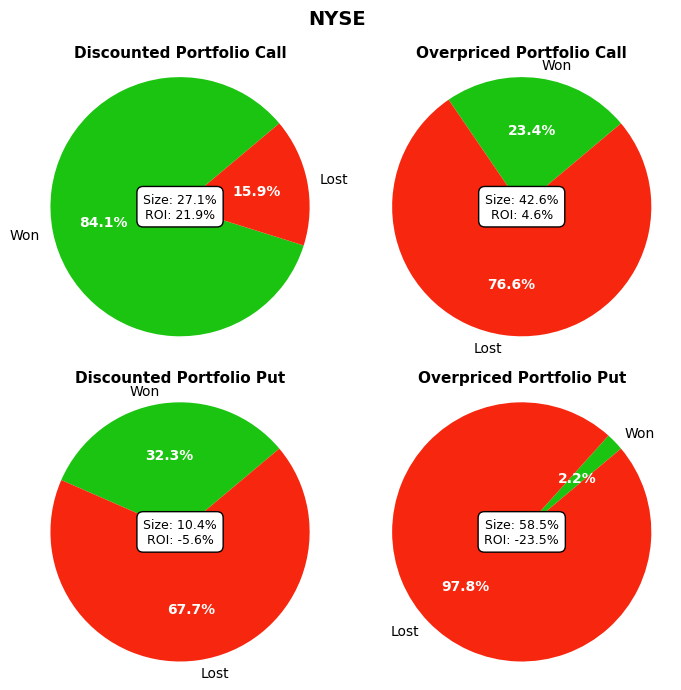

In [17]:
#### SAME ANALYSIS BUT BREAKING UP BY STOCK MARKET #####


NMS_Data_put = Data_put[Data_put['market'] == 'NMS']
NMS_Data_call = Data_call[Data_call['market'] == 'NMS']

print(len(NMS_Data_call))
print(len(NMS_Data_put))

NMS_portfolio_put, NMS_not_portfolio_put, NMS_portfolio_call, NMS_not_portfolio_call = generate_portfolios(NMS_Data_call, NMS_Data_put)
NMS_portfolio_call_stats  = calculate_profit_stats(NMS_portfolio_call, True)
NMS_not_portfolio_call_stats  = calculate_profit_stats(NMS_not_portfolio_call, True)
NMS_portfolio_put_stats  = calculate_profit_stats(NMS_portfolio_put, False)
NMS_not_portfolio_put_stats  = calculate_profit_stats(NMS_not_portfolio_put, False)


# Titles for each chart
titles = [
    "Discounted Portfolio Call",
    "Overpriced Portfolio Call",
    "Discounted Portfolio Put",
    "Overpriced Portfolio Put",
    "NYSE"
]

# Generate a single figure with four pie charts using the updated stats
generate_four_pie_charts(
    NMS_portfolio_call_stats, NMS_not_portfolio_call_stats,
    NMS_portfolio_put_stats, NMS_not_portfolio_put_stats,
    titles
)


1214
1197


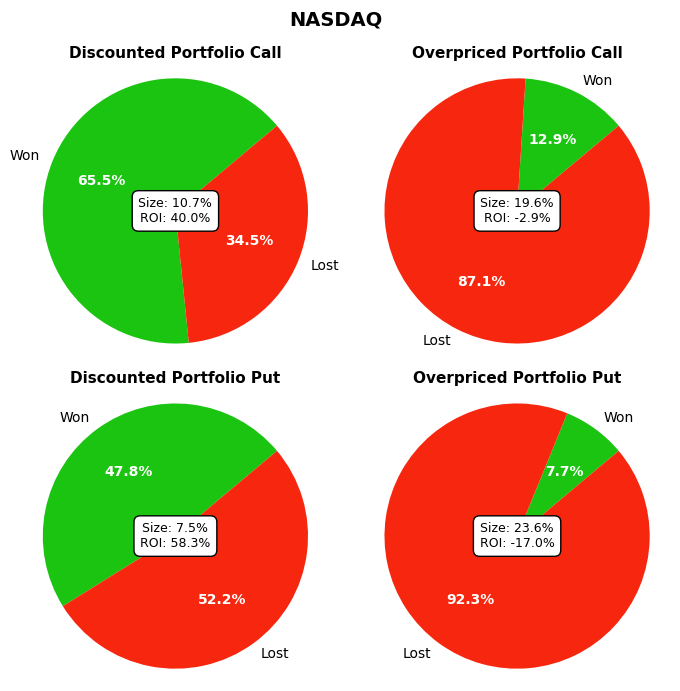

In [18]:
NYQ_Data_put = Data_put[Data_put['market'] == 'NYQ']
NYQ_Data_call = Data_call[Data_call['market'] == 'NYQ']

print(len(NYQ_Data_call))
print(len(NYQ_Data_put))

NYQ_portfolio_put, NYQ_not_portfolio_put, NYQ_portfolio_call, NYQ_not_portfolio_call = generate_portfolios(NYQ_Data_call, NYQ_Data_put)
NYQ_portfolio_call_stats  = calculate_profit_stats(NYQ_portfolio_call, True)
NYQ_not_portfolio_call_stats  = calculate_profit_stats(NYQ_not_portfolio_call, True)
NYQ_portfolio_put_stats  = calculate_profit_stats(NYQ_portfolio_put, False)
NYQ_not_portfolio_put_stats  = calculate_profit_stats(NYQ_not_portfolio_put, False)

# Titles for each chart
titles = [
    "Discounted Portfolio Call",
    "Overpriced Portfolio Call",
    "Discounted Portfolio Put",
    "Overpriced Portfolio Put",
    "NASDAQ"
]

# Generate a single figure with four pie charts using the updated stats
generate_four_pie_charts(
    NYQ_portfolio_call_stats, NYQ_not_portfolio_call_stats,
    NYQ_portfolio_put_stats, NYQ_not_portfolio_put_stats,
    titles
)


In [19]:
Data_put.to_csv('/Users/judd/Desktop/put.csv')

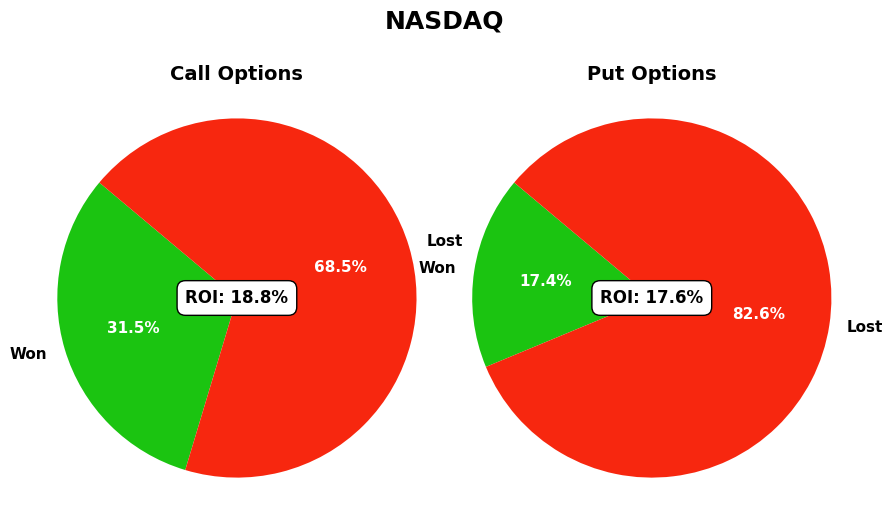

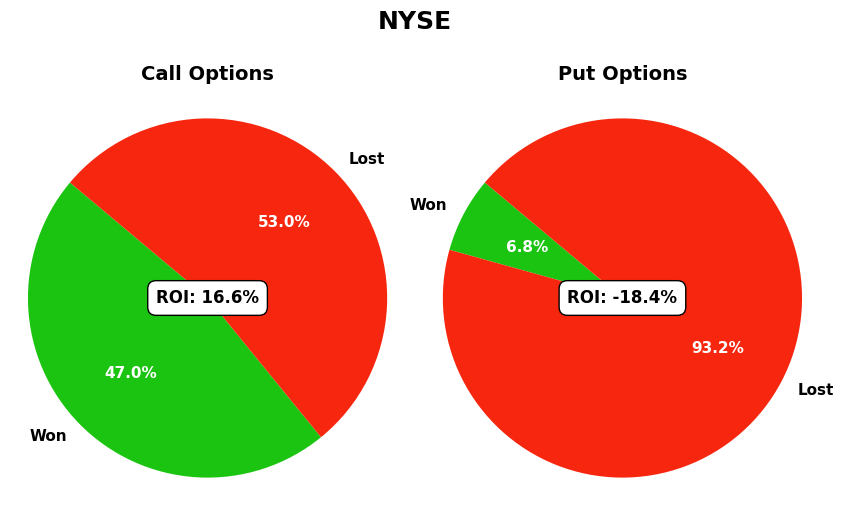

In [20]:
#### Benchmarking results ### 


### Purchasing all options @ live price performance #####

def generate_two_pie_charts(stats1, stats2, titles):
    # Unpack the titles
    title1, title2, title3 = titles
    
    # Create a smaller 1x2 subplot structure with adjusted figure size
    fig, axs = plt.subplots(1, 2, figsize=(9, 6))  # Increase the size for a cleaner look

    # Apply a tighter layout with minimal padding
    fig.tight_layout(pad=1.0, h_pad=0.1, w_pad=0.1)  # Reduce overall padding

    # Further adjust spacing between subplots and figure borders
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.05, hspace=0.05)


    # Data for each pie chart
    chart_data = [
        (stats1, axs[0], title1),
        (stats2, axs[1], title2)
    ]

    # Updated colors: rich blue and red
    colors = ['#1bc411', '#f7270f']  # Standard rich blue and red

    # Generate pie charts for each subplot
    for stats, ax, title in chart_data:
        _, _, total_profit, percent_positive, percent_negative = stats
        sizes = [percent_positive, percent_negative]
        labels = ['Won', 'Lost']

        # Create the pie chart
        wedges, texts, autotexts = ax.pie(
            sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 11, 'fontweight': 'bold'}
        )
        ax.set_title(title, fontsize=14, weight='bold')
        ax.axis('equal')  # Ensures the pie is drawn as a circle

        # Customize the text properties inside the pie
        for autotext in autotexts:
            autotext.set_fontsize(11)
            autotext.set_weight('bold')
            autotext.set_color('white')  # Change color to white for better readability

        # Customize the labels outside the pie chart ("Won" and "Lost") to match the text style
        for text in texts:
            text.set_fontsize(11)
            text.set_fontweight('bold')

        # Format portfolio size with commas and format total profit using custom format
        formatted_profit = f"{total_profit * 100:.1f}%"
        
        # Add portfolio size and total profit in the center of the pie chart with a custom text box
        textstr = f"ROI: {formatted_profit}"
        ax.text(
            0, 0, textstr, ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
        )

        # Add an overall title to the entire figure
        fig.suptitle(title3, fontsize=18, weight='bold')
        

    plt.show()

# Assuming you have these variables from the updated `calculate_profit_stats` function


all_call_stats_NYQ = calculate_profit_stats(NYQ_Data_call, True)
all_put_stats_NYQ = calculate_profit_stats(NYQ_Data_put, False)

all_call_stats_NMS = calculate_profit_stats(NMS_Data_call, True)
all_put_stats_NMS = calculate_profit_stats(NMS_Data_put, False)


# Titles for each chart
titles_NYQ = [
    "Call Options",
    "Put Options", "NASDAQ"]

titles_NMS= [
    "Call Options",
    "Put Options", "NYSE"]

# Generate a single figure with four pie charts using the updated stats
generate_two_pie_charts(
all_call_stats_NYQ, all_put_stats_NYQ, titles_NYQ
)

generate_two_pie_charts(
all_call_stats_NMS, all_put_stats_NMS, titles_NMS
)


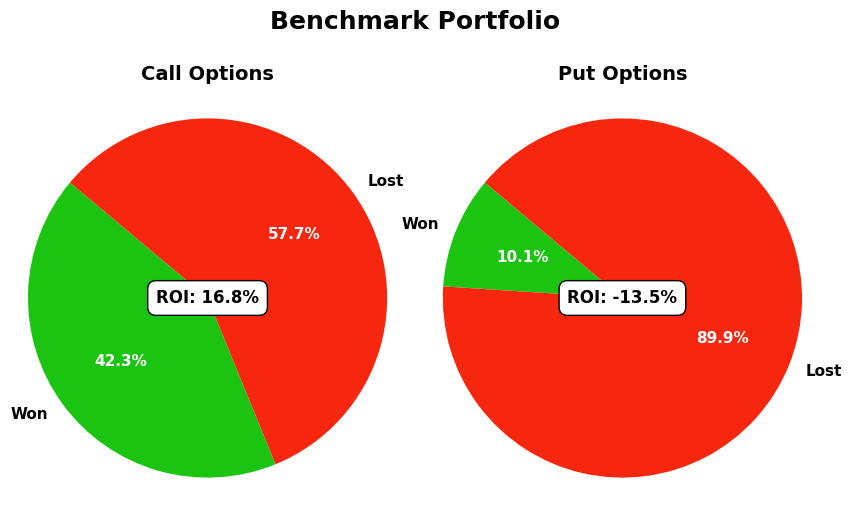

In [21]:
#### Benchmarking results ### 


### Purchasing all options @ live price performance #####

def generate_two_pie_charts(stats1, stats2, titles):
    # Unpack the titles
    title1, title2, title3 = titles
    
    # Create a smaller 1x2 subplot structure with adjusted figure size
    fig, axs = plt.subplots(1, 2, figsize=(9, 6))  # Increase the size for a cleaner look

    # Apply a tighter layout with minimal padding
    fig.tight_layout(pad=1.0, h_pad=0.1, w_pad=0.1)  # Reduce overall padding

    # Further adjust spacing between subplots and figure borders
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.05, hspace=0.05)


    # Data for each pie chart
    chart_data = [
        (stats1, axs[0], title1),
        (stats2, axs[1], title2)
    ]

    # Updated colors: rich blue and red
    colors = ['#1bc411', '#f7270f']  # Standard rich blue and red

    # Generate pie charts for each subplot
    for stats, ax, title in chart_data:
        _, _, total_profit, percent_positive, percent_negative = stats
        sizes = [percent_positive, percent_negative]
        labels = ['Won', 'Lost']

        # Create the pie chart
        wedges, texts, autotexts = ax.pie(
            sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 11, 'fontweight': 'bold'}
        )
        ax.set_title(title, fontsize=14, weight='bold')
        ax.axis('equal')  # Ensures the pie is drawn as a circle

        # Customize the text properties inside the pie
        for autotext in autotexts:
            autotext.set_fontsize(11)
            autotext.set_weight('bold')
            autotext.set_color('white')  # Change color to white for better readability

        # Customize the labels outside the pie chart ("Won" and "Lost") to match the text style
        for text in texts:
            text.set_fontsize(11)
            text.set_fontweight('bold')

        # Format portfolio size with commas and format total profit using custom format
        formatted_profit = f"{total_profit * 100:.1f}%"
        
        # Add portfolio size and total profit in the center of the pie chart with a custom text box
        textstr = f"ROI: {formatted_profit}"
        ax.text(
            0, 0, textstr, ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
        )

        # Add an overall title to the entire figure
        fig.suptitle(title3, fontsize=18, weight='bold')
        

    plt.show()

# Assuming you have these variables from the updated `calculate_profit_stats` function


all_call_stats= calculate_profit_stats(Data_call, True)
all_put_stats = calculate_profit_stats(Data_put, False)


# Titles for each chart
titles = [
    "Call Options",
    "Put Options", "Benchmark Portfolio"]


# Generate a single figure with four pie charts using the updated stats
generate_two_pie_charts(
all_call_stats, all_put_stats, titles

)

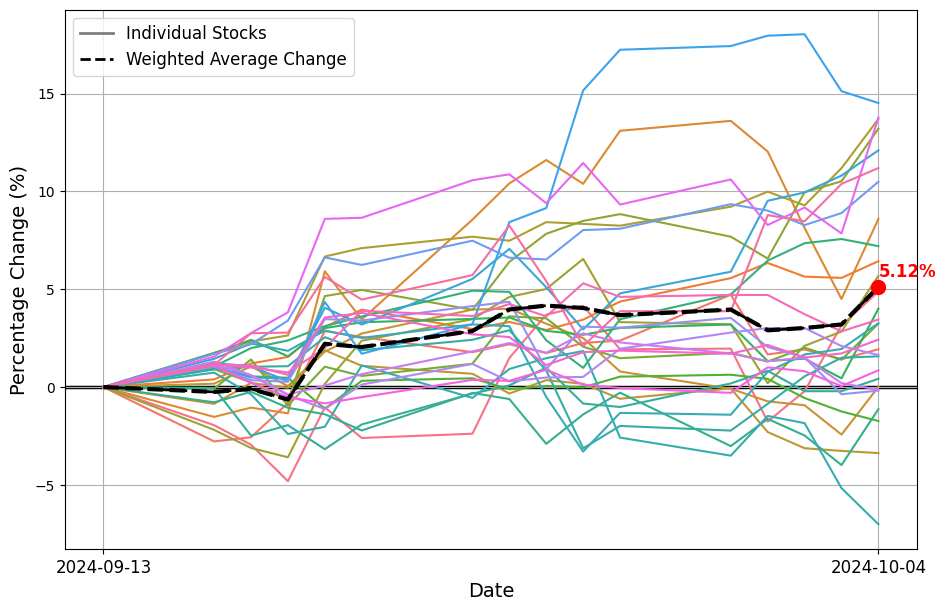

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from matplotlib.lines import Line2D

# Define the function to fetch historical stock data
def fetch_historical_stock_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    return ticker.history(period="1mo")

# Assuming Data_put contains the list of stocks and their occurrences
unique_stocks = Data_put['stock'].unique()
palette = sns.color_palette("husl", len(unique_stocks))
color_mapping = dict(zip(unique_stocks, palette))

# Calculate the number of appearances of each stock in Data_put
stock_weights = Data_put['stock'].value_counts(normalize=True)

# Create a dictionary to store the historical data for each stock
historical_data_dict = {}
for stock in unique_stocks:
    historical_data_dict[stock] = fetch_historical_stock_data(stock)

# Create a DataFrame with the 'Date' index and individual 'Close' prices for each stock
combined_df = pd.DataFrame(index=historical_data_dict[unique_stocks[0]].index)
for stock in unique_stocks:
    combined_df[stock] = historical_data_dict[stock]['Close']

# Filter the DataFrame to only include data between Sept 13 and Oct 4
combined_df = combined_df.loc['2024-09-13':'2024-10-04']

# Calculate the percentage change relative to the first value for each stock in the filtered range
percentage_df = combined_df.apply(lambda x: (x - x.iloc[0]) / x.iloc[0] * 100)

# Identify and remove outliers based on a fixed threshold
outlier_threshold = 50  # Define an outlier threshold (e.g., 50% change)
non_outlier_stocks = percentage_df.columns[percentage_df.max() < outlier_threshold]

# Filter the DataFrame to exclude outlier stocks
filtered_percentage_df = percentage_df[non_outlier_stocks]

# Ensure the weights only include non-outlier stocks
filtered_weights = stock_weights[non_outlier_stocks]

# Calculate the weighted average percentage change for the filtered stocks
weighted_average_change = (filtered_percentage_df * filtered_weights).sum(axis=1) / filtered_weights.sum()

# Add the weighted average change as a new column in the filtered DataFrame
filtered_percentage_df['Weighted Average Change'] = weighted_average_change

# Identify the last date and the corresponding value of the Weighted Average Change
last_date = filtered_percentage_df.index[-1]
last_value = filtered_percentage_df['Weighted Average Change'].iloc[-1]



# Create the plot with the specified size
plt.figure(figsize=(11, 7))

# Plot each filtered stock with its assigned colors
for stock in non_outlier_stocks:
    plt.plot(filtered_percentage_df.index, filtered_percentage_df[stock], label=f'{stock}', color=color_mapping[stock])

# Plot the weighted average percentage change with a distinct style
plt.plot(filtered_percentage_df.index, filtered_percentage_df['Weighted Average Change'], label='Weighted Average Change', color='black', linestyle='--', linewidth=3)

# Add a data point marker at the last value of the Weighted Average Change
last_date = filtered_percentage_df.index[-1]
last_value = filtered_percentage_df['Weighted Average Change'].iloc[-1]
plt.scatter(last_date, last_value, color='red', s=100, zorder=5)  # Red marker with increased size
weighted_avg_line, = plt.plot(filtered_percentage_df.index, filtered_percentage_df['Weighted Average Change'],
                              label='Weighted Average Change', color='black', linestyle='--', linewidth=2)

# Annotate the data point with improved positioning
plt.text(last_date, last_value + 0.75, f'{last_value:.2f}%', color='red', fontsize=12, ha='left', va='center', weight='bold')

# Customizing the plot
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=14)

# Set x-ticks to show only the first and last date with a specific font size
plt.xticks([filtered_percentage_df.index[0], filtered_percentage_df.index[-1]],  # Only show first and last date
           labels=[filtered_percentage_df.index[0].strftime('%Y-%m-%d'), filtered_percentage_df.index[-1].strftime('%Y-%m-%d')],
           fontsize=12)  # Set font size to 12

# Add a thick horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=2.5, zorder=0)
individual_stocks_line = Line2D([0], [0], color='gray', linestyle='-', linewidth=2)  # Dummy line for the legend

# Add a legend for both the black dotted line and the individual stocks
plt.legend([individual_stocks_line, weighted_avg_line],
           ['Individual Stocks', 'Weighted Average Change'],
           fontsize=12, loc='upper left')


# Show the plot
plt.grid(True)
plt.show()




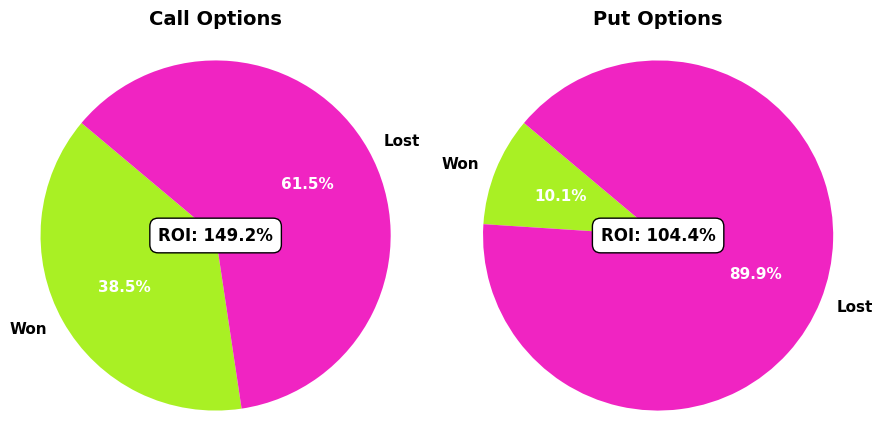

In [23]:
### What if live price was our BSM prediction ####


def generate_two_pie_charts_2(stats1, stats2, titles):
    # Unpack the titles
    title1, title2, title3 = titles
    
    # Create a smaller 2x2 subplot structure with adjusted figure size
    fig, axs = plt.subplots(1, 2, figsize=(9,6))  # Increase the size for a cleaner look

    # Data for each pie chart
    chart_data = [
        (stats1, axs[0], title1),
        (stats2, axs[1], title2)
    ]

    # Updated colors: rich blue and red
    colors = ['#a9f024', '#f024c2']  # Standard rich blue and red

    # Generate pie charts for each subplot
    for stats, ax, title in chart_data:
        _, _, total_profit, percent_positive, percent_negative = stats
        sizes = [percent_positive, percent_negative]
        labels = ['Won', 'Lost']

        # Create the pie chart
        wedges, texts, autotexts = ax.pie(
            sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 11, 'fontweight': 'bold'}
        )
        ax.set_title(title, fontsize=14, weight='bold')
        ax.axis('equal')  # Ensures the pie is drawn as a circle

        # Customize the text properties inside the pie
        for autotext in autotexts:
            autotext.set_fontsize(11)
            autotext.set_weight('bold')
            autotext.set_color('white')  # Change color to white for better readability

        # Customize the labels outside the pie chart ("Won" and "Lost") to match the text style
        for text in texts:
            text.set_fontsize(11)
            text.set_fontweight('bold')

        # Format portfolio size with commas and format total profit using custom format
        formatted_profit = f"{total_profit * 100:.1f}%"
        
        # Add portfolio size and total profit in the center of the pie chart with a custom text box
        textstr = f"ROI: {formatted_profit}"
        ax.text(
            0, 0, textstr, ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
        )


    # Add an overall title to the entire figure
    #fig.suptitle(title3, fontsize=18, weight='bold')
    
    # Display the pie charts
    plt.tight_layout()
    plt.subplots_adjust(top=0.7)  # Adjust layout to fit the main title
    plt.show()

def calculate_profit_stats_bsm_base(df, call = True):

    if call == True:
        portfolio_size = len(df)/len(Data_call)
    else:
        portfolio_size = len(df)/len(Data_put)
    
    # Calculate the number of rows with positive profit
    num_positive_profit_rows = len(df[df['profit_bsm_base'] > 0.5])
    
    # Calculate the number of rows with negative profit
    num_negative_profit_rows = len(df[df['profit_bsm_base'] < 0.5])
    
    
    # Calculate percentages
    percent_positive = (num_positive_profit_rows / len(df)) * 100 
    percent_negative = (num_negative_profit_rows / len(df)) * 100 

    # Calculate the total profit (sum of all profit values)
    total_profit = df['profit'].sum() / sum(df['profit_bsm_base'])  #### Return on Investment (ROI)

    return  portfolio_size, num_positive_profit_rows, total_profit, percent_positive, percent_negative

all_call_stats_bsm_base = calculate_profit_stats_bsm_base(Data_call, True)
all_put_stats_bsm_base  = calculate_profit_stats_bsm_base(Data_put, False)

# Titles for each chart
titles = [
    "Call Options",
    "Put Options", "Using BSM as Live Price"]

# Generate a single figure with four pie charts using the updated stats
generate_two_pie_charts_2(
all_call_stats_bsm_base , all_put_stats_bsm_base , titles
)

In [24]:
## PROFIT FOR THE STOCK MARKET ####

Data_put['profit_for_market']  = np.where(
        Data_put['strike_price'] - Data_put['closing_price_at_expiry'] - Data_put['live_last_price'] > -Data_put['live_last_price'],
        Data_put['live_last_price'] - Data_put['strike_price'] + Data_put['closing_price_at_expiry'],
        Data_put['live_last_price']
    )


Data_put['profit_for_market_bsm_base']  = np.where(
        Data_put['strike_price'] - Data_put['closing_price_at_expiry'] - Data_put['bsm'] > -Data_put['bsm'],
        Data_put['bsm'] - Data_put['strike_price'] + Data_put['closing_price_at_expiry'],
        Data_put['bsm']
    )


Data_call['profit_for_market'] = np.where(
        Data_call['closing_price_at_expiry'] -  Data_call['strike_price'] - Data_call['live_last_price'] > -Data_call['live_last_price'],
        Data_call['live_last_price'] + Data_call['strike_price'] - Data_call['closing_price_at_expiry'] ,
        Data_call['live_last_price'])


Data_call['profit_for_market_bsm_base'] = np.where(
        Data_call['closing_price_at_expiry'] -  Data_call['strike_price'] - Data_call['bsm'] > -Data_call['bsm'],
        Data_call['bsm'] + Data_call['strike_price'] - Data_call['closing_price_at_expiry'] ,
        Data_call['bsm'])


def calculate_profit_stats_for_market(df, call = True, bsm_base = True):

    if call == True:
        portfolio_size = len(df)
    else:
        portfolio_size = len(df)
    
    # Calculate the total profit (sum of all profit values)

    if bsm_base == True:
        total_profit = 100* df['profit_for_market_bsm_base'].sum() / sum(df['bsm'])  #### % Profit on Sales
        # Calculate the number of rows with positive profit
        num_positive_profit_rows = len(df[df['profit_for_market_bsm_base'] > 0])
        # Calculate the number of rows with negative profit
        num_negative_profit_rows = len(df[df['profit_for_market_bsm_base'] < 0])
    else:
        total_profit =100* df['profit_for_market'].sum() / sum(df['live_last_price'])  #### % Profit on Sales
        # Calculate the number of rows with positive profit
        num_positive_profit_rows = len(df[df['profit_for_market'] > 0])
        # Calculate the number of rows with negative profit
        num_negative_profit_rows = len(df[df['profit_for_market'] < 0])

    # Calculate percentages
    percent_positive = (num_positive_profit_rows / len(df)) * 100 
    percent_negative = (num_negative_profit_rows / len(df)) * 100 

    # Calculate percentages
    percent_positive = (num_positive_profit_rows / len(df)) * 100 
    percent_negative = (num_negative_profit_rows / len(df)) * 100 

    return  portfolio_size, num_positive_profit_rows, total_profit, percent_positive, percent_negative




all_call_stats_bsm_base = calculate_profit_stats_for_market(Data_call, True, True)
all_put_stats_bsm_base  = calculate_profit_stats_for_market(Data_put, False, True)

all_call_stats = calculate_profit_stats_for_market(Data_call, True, False)
all_put_stats = calculate_profit_stats_for_market(Data_put, False, False)



print(all_call_stats_bsm_base)
print(all_put_stats_bsm_base )
print(all_call_stats)
print(all_put_stats)

(4007, 1866, np.float64(-10.681461444793333), 46.568505116046914, 42.15123533815822)
(3851, 2820, np.float64(12.672535471759467), 73.227733056349, 9.763697740846533)
(4007, 2204, np.float64(-16.821153012440256), 55.003743448964315, 44.971300224606935)
(3851, 3409, np.float64(13.470750011504006), 88.52246169826019, 11.477538301739807)


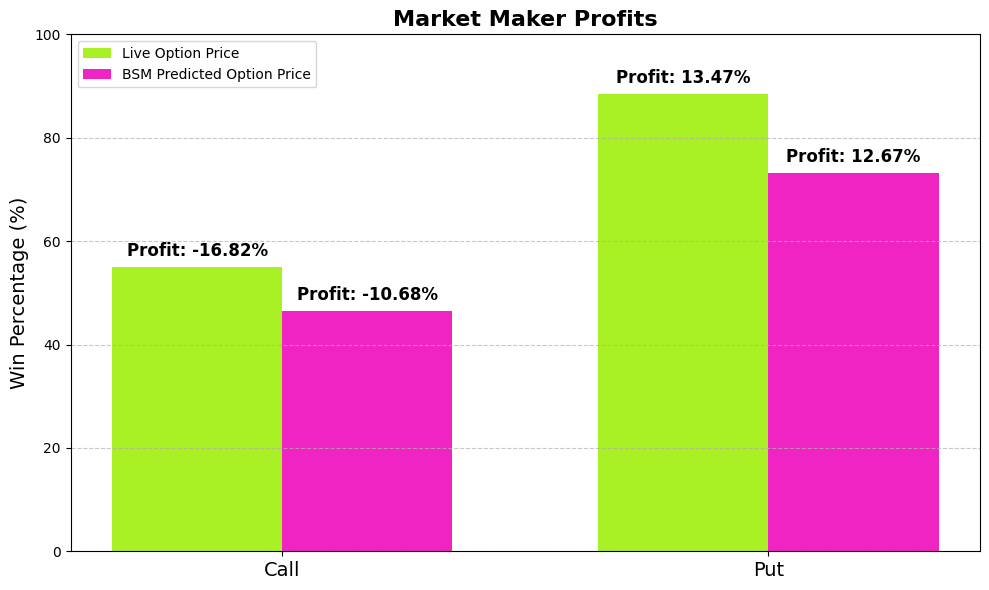

In [25]:

# Example data: percentage of wins and corresponding profits for Call and Put markets
markets = ['Call', 'Put']  # X-axis labels for Call and Put markets
win_percent_price_a  = [all_call_stats[-2], all_put_stats[-2]]  # Wins for Option Price A [Call, Put]
win_percent_price_b = [all_call_stats_bsm_base[-2], all_put_stats_bsm_base[-2]]  # Wins for Option Price B [Call, Put]
profits_price_a = [all_call_stats[2], all_put_stats[2]]  # Profits for Option Price A [Call, Put]
profits_price_b = [all_call_stats_bsm_base[2], all_put_stats_bsm_base[2]]   # Profits for Option Price B [Call, Put]

# Define positions for the bars
x = np.arange(len(markets))  # Positions for Call and Put on x-axis
width = 0.35  # Width of the bars

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

 
# Bars for Option Price A
bars_a = ax.bar(x - width/2, win_percent_price_a, width=width, label='Live Option Price', color='#a9f024')
# Bars for Option Price B
bars_b = ax.bar(x + width/2, win_percent_price_b, width=width, label='BSM Predicted Option Price', color='#f024c2')

# Annotate Option Price A bars with rounded profits
for bar, profit in zip(bars_a, profits_price_a):
    height = bar.get_height()
    ax.annotate(f'Profit: {profit:.2f}%',  # Annotation text rounded to 2 decimal places
                xy=(bar.get_x() + bar.get_width() / 2, height),  # Position at the top of the bar
                xytext=(0, 5),  # Offset by 5 points above the bar
                textcoords='offset points',
                ha='center', va='bottom',  # Center the text horizontally
                fontsize=12, fontweight='bold', color='black')

# Annotate Option Price B bars with rounded profits
for bar, profit in zip(bars_b, profits_price_b):
    height = bar.get_height()
    ax.annotate(f'Profit: {profit:.2f}%',  # Annotation text rounded to 2 decimal places
                xy=(bar.get_x() + bar.get_width() / 2, height),  # Position at the top of the bar
                xytext=(0, 5),  # Offset by 5 points above the bar
                textcoords='offset points',
                ha='center', va='bottom',  # Center the text horizontally
                fontsize=12, fontweight='bold', color='black')

# Set the y-axis to show percentage values
ax.set_ylim(0, 100)  # Ensure y-axis goes up to 100%
ax.set_ylabel('Win Percentage (%)', fontsize=14)  # Update y-axis label

# Set the x-axis labels and title
ax.set_title('Market Maker Profits', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(markets, fontsize=14)  # Use "Call" and "Put" as x-axis labels

ax.legend()  # Add a legend with the title
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
# Display the plot
plt.tight_layout()
plt.show()



In [26]:
import scipy.stats as si


def days_between(start_date, end_date):
    """
    Calculate the number of days between the start date and the end date.

    Parameters:
    - start_date: Start date as a string, datetime, or Timestamp object.
    - end_date: End date as a string, datetime, or Timestamp object.

    Returns:
    - Number of days between start_date and end_date.
    """
    # Convert to datetime if the input is not a datetime object already
    if not isinstance(start_date, datetime):
        start_date = pd.to_datetime(start_date).date()
    else:
        start_date = start_date.date()  # Extract only the date part

    if not isinstance(end_date, datetime):
        end_date = pd.to_datetime(end_date).date()
    else:
        end_date = end_date.date()  # Extract only the date part

    # Calculate the difference in days
    delta = end_date - start_date

    # Return the number of days
    return delta.days


class BlackScholesModel:
    def __init__(self, S, K, T_days, r, sigma):
        self.S = S        # Underlying asset price
        self.K = K        # Option strike price
        self.T = T_days / 365    # Time to expiration in years (converting days to years)
        self.r = r        # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_option_price(self):
        return (self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0))
    


def fetch_historical_stock_data(ticker_symbol):
    # Create a YF Finance Ticker object
    ticker = yf.Ticker(ticker_symbol)
    # Fetch historical market data
    return ticker.history(period="1y") 


for index, row in Data_put.iterrows():
    Data_put.at[index, 'bsm_ml_vol'] = BlackScholesModel(S=fetch_historical_stock_data(row['stock'])['Close']['2024-09-12'], K=row['strike_price'], T_days=days_between('2024-09-13', row['expiry_date'] ), r=0.0525, sigma=row['ML_volatility']).put_option_price()


for index, row in Data_call.iterrows():
    Data_call.at[index, 'bsm_ml_vol']  = BlackScholesModel(S=fetch_historical_stock_data(row['stock'])['Close']['2024-09-12'], K=row['strike_price'], T_days=days_between('2024-09-13', row['expiry_date'] ), r=0.0525, sigma=row['ML_volatility']).put_option_price()



/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_39786/2692486438.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_39786/2692486438.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_39786/2692486438.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_39786/2692486438.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma

KeyboardInterrupt: 

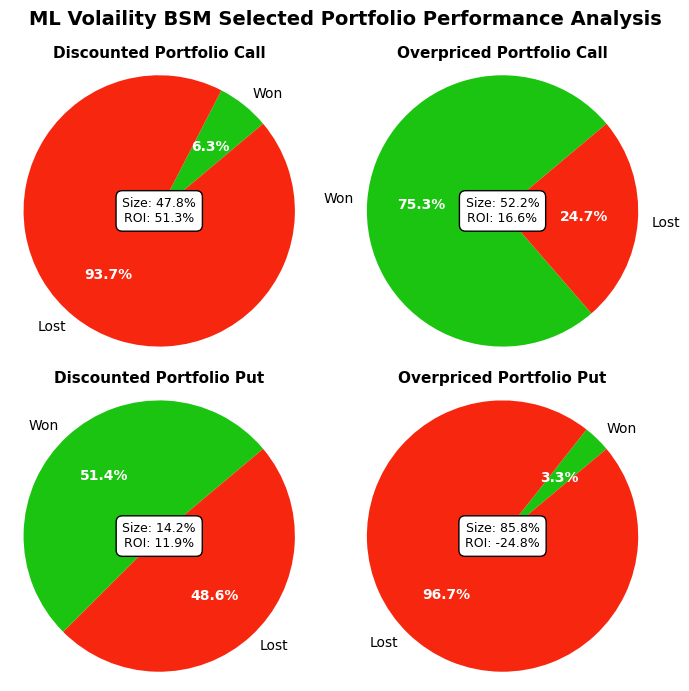

In [ ]:

def generate_portfolios_BSM_ML(Data_call, Data_put):
    portfolio_call = Data_call[Data_call['bsm_ml_vol'] >= Data_call['live_last_price']]
    portfolio_put = Data_put[Data_put['bsm_ml_vol'] >= Data_put['live_last_price']]
    not_portfolio_call = Data_call[Data_call['bsm_ml_vol'] < Data_call['live_last_price']]
    not_portfolio_put = Data_put[Data_put['bsm_ml_vol'] < Data_put['live_last_price']]
    
    return portfolio_put, not_portfolio_put, portfolio_call, not_portfolio_call


portfolio_put_ML, not_portfolio_put_ML, portfolio_call_ML, not_portfolio_call_ML = generate_portfolios_BSM_ML(Data_call, Data_put)


portfolio_call_stats_ML  = calculate_profit_stats(portfolio_call_ML , True)
not_portfolio_call_stats_ML   = calculate_profit_stats(not_portfolio_call_ML , True)
portfolio_put_stats_ML   = calculate_profit_stats(portfolio_put_ML , False)
not_portfolio_put_stats_ML  = calculate_profit_stats(not_portfolio_put_ML , False)


# Titles for each chart
titles = [
    "Discounted Portfolio Call",
    "Overpriced Portfolio Call",
    "Discounted Portfolio Put",
    "Overpriced Portfolio Put",
    "ML Volaility BSM Selected Portfolio Performance Analysis"
]

# Generate a single figure with four pie charts using the updated stats
generate_four_pie_charts(
    portfolio_call_stats_ML , not_portfolio_call_stats_ML ,
    portfolio_put_stats_ML , not_portfolio_put_stats_ML ,
    titles)